# Imports

In [12]:
import gzip
import numpy as np
import struct
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from tqdm import tqdm
from sklearn.preprocessing import RobustScaler

# Loading Dataset

Reference: http://yann.lecun.com/exdb/mnist/

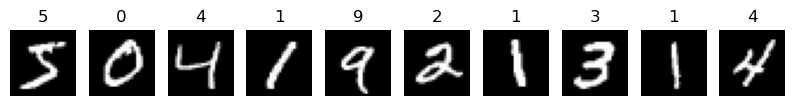

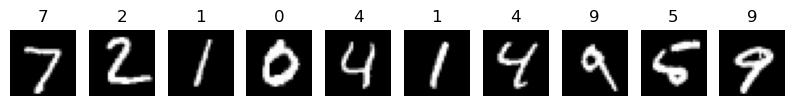

In [2]:
def read_idx_file(filename):
    with gzip.open(filename, 'rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        if magic == 2051:
            rows, cols = struct.unpack(">II", f.read(8))
            data = np.frombuffer(f.read(), dtype=np.uint8).reshape((size, rows, cols))
        elif magic == 2049:
            data = np.frombuffer(f.read(), dtype=np.uint8)
        else:
            raise ValueError("Invalid file format")
    return data

def plot_images(images, labels):
    plt.figure(figsize=(10, 1))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

train_images = read_idx_file('mnist-dataset/train-images-idx3-ubyte.gz')[:500]
train_labels = read_idx_file('mnist-dataset/train-labels-idx1-ubyte.gz')[:500]
test_images = read_idx_file('mnist-dataset/t10k-images-idx3-ubyte.gz')[:250]
test_labels = read_idx_file('mnist-dataset/t10k-labels-idx1-ubyte.gz')[:250]

plot_images(train_images, train_labels)
plot_images(test_images, test_labels)

# Convert to Graph

/tmp/ipykernel_19541/1200697171.py:22: RuntimeWarning: overflow encountered in scalar subtract
  weight_down = abs(G.nodes[current_node]['pixel_value'] - G.nodes[down_node]['pixel_value'])
/tmp/ipykernel_19541/1200697171.py:21: RuntimeWarning: overflow encountered in scalar subtract
  weight_right = abs(G.nodes[current_node]['pixel_value'] - G.nodes[right_node]['pixel_value'])


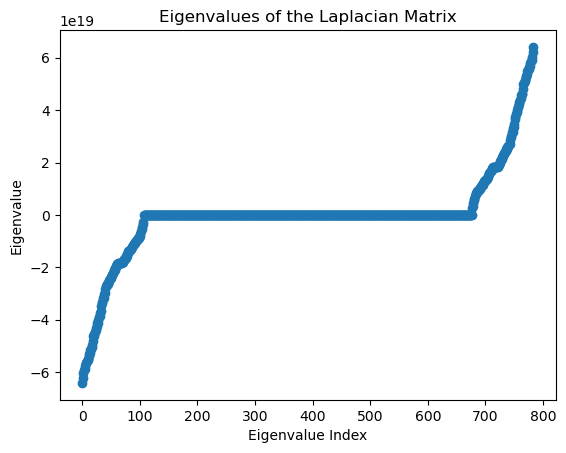

Average Degree: 3.7193877551020407
Clustering Coefficient: 0.0


In [6]:
def analyze_image_features(image):
    G = nx.Graph()

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            node_id = (i, j)
            pixel_value = image[i, j]
            G.add_node(node_id, pixel_value=pixel_value)

    for i in range(image.shape[0] - 1):
        for j in range(image.shape[1] - 1):
            current_node = (i, j)
            right_node = (i, j + 1)
            down_node = (i + 1, j)

            # Add edges with weight based on pixel value difference
            weight_right = abs(G.nodes[current_node]['pixel_value'] - G.nodes[right_node]['pixel_value'])
            weight_down = abs(G.nodes[current_node]['pixel_value'] - G.nodes[down_node]['pixel_value'])

            G.add_edge(current_node, right_node, weight=weight_right)
            G.add_edge(current_node, down_node, weight=weight_down)

    laplacian_matrix = nx.laplacian_matrix(G).todense()    

    eigenvalues, _ = np.linalg.eigh(laplacian_matrix)

    average_degree = np.mean(list(dict(G.degree()).values()))

    clustering_coefficient = nx.average_clustering(G)

    return laplacian_matrix, eigenvalues, average_degree, clustering_coefficient

image = train_images[0]

laplacian_matrix, eigenvalues, average_degree, clustering_coefficient = analyze_image_features(image)

plt.plot(eigenvalues, marker='o')
plt.title("Eigenvalues of the Laplacian Matrix")
plt.xlabel("Eigenvalue Index")
plt.ylabel("Eigenvalue")
plt.show()

print("Average Degree:", average_degree)
print("Clustering Coefficient:", clustering_coefficient)

In [7]:
X_train, Y_train = [], []

for image in tqdm(train_images):
    laplacian_matrix, eigenvalues, average_degree, clustering_coefficient = analyze_image_features(image)
    eigenvalues = eigenvalues.real.astype(np.float32)
    X_train.append(eigenvalues)

for label in train_labels:
    Y_train.append(label)

  0%|                                                   | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_19541/1200697171.py:22: RuntimeWarning: overflow encountered in scalar subtract
  weight_down = abs(G.nodes[current_node]['pixel_value'] - G.nodes[down_node]['pixel_value'])
/tmp/ipykernel_19541/1200697171.py:21: RuntimeWarning: overflow encountered in scalar subtract
  weight_right = abs(G.nodes[current_node]['pixel_value'] - G.nodes[right_node]['pixel_value'])
100%|█████████████████████████████████████████| 500/500 [00:45<00:00, 10.89it/s]


In [9]:
X_test, Y_test = [], []

for image in tqdm(test_images):
    laplacian_matrix, eigenvalues, average_degree, clustering_coefficient = analyze_image_features(image)
    eigenvalues = eigenvalues.real.astype(np.float32)
    X_test.append(eigenvalues)

for label in test_labels:
    Y_test.append(label)

  0%|                                                   | 0/250 [00:00<?, ?it/s]/tmp/ipykernel_19541/1200697171.py:22: RuntimeWarning: overflow encountered in scalar subtract
  weight_down = abs(G.nodes[current_node]['pixel_value'] - G.nodes[down_node]['pixel_value'])
/tmp/ipykernel_19541/1200697171.py:21: RuntimeWarning: overflow encountered in scalar subtract
  weight_right = abs(G.nodes[current_node]['pixel_value'] - G.nodes[right_node]['pixel_value'])
100%|█████████████████████████████████████████| 250/250 [00:19<00:00, 13.02it/s]


In [13]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = X_train_scaled

# Classification

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

classifier = SVC(kernel='linear', C=1)

classifier.fit(X_train, Y_train)

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
conf_matrix = confusion_matrix(Y_test, y_pred)
classification_report_str = classification_report(Y_test, y_pred)

print("Accuracy:", accuracy)
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report_str)